In [112]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score


In [113]:
pd.set_option("display.max_columns", 100)
%matplotlib inline
RANDOM_SEED = 6

In [114]:
DATA_PATH = Path.cwd() / ""
train_df = pd.read_csv(DATA_PATH / "train.csv", index_col="tripid")
test_df =  pd.read_csv(DATA_PATH / "test.csv", index_col="tripid")
train_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [115]:
numerical_features = train_df.columns[train_df.dtypes != "object"].values
categorical_features = train_df.columns[train_df.dtypes == "object"].values


In [116]:
numerical_features

array(['additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare'], dtype=object)

In [117]:
categorical_features

array(['pickup_time', 'drop_time', 'label'], dtype=object)

In [118]:
train_df['checkout_datetime'] = pd.to_datetime(train_df['drop_time'])
train_df['checkin_datetime'] = pd.to_datetime(train_df['pickup_time'])
#train_df['duration'] = train_df['checkout_datetime']-train_df['checkin_datetime']
train_df['duration_in_minutes'] = (train_df['checkout_datetime']-train_df['checkin_datetime'])/pd.Timedelta(minutes=1)
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,checkout_datetime,checkin_datetime,duration_in_minutes
tripid,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.000000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,2019-11-01 00:34:00,2019-11-01 00:20:00,14.0
189125358,10.5,791.0,47.0,0.000000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,2019-11-01 01:09:00,2019-11-01 00:56:00,13.0
189125719,10.5,1087.0,80.0,0.000000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,2019-11-01 01:26:00,2019-11-01 01:08:00,18.0
189127273,10.5,598.0,271.0,15.663800,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,2019-11-01 02:37:00,2019-11-01 02:27:00,10.0
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct,2019-11-01 03:51:00,2019-11-01 03:34:00,17.0
189129552,10.5,3407.0,182.0,0.000000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct,2019-11-01 06:35:00,2019-11-01 05:38:00,57.0
189132829,10.5,1246.0,487.0,0.000000,133.0,11/1/2019 6:29,11/1/2019 6:49,6.84371,79.9051,6.85069,79.8624,266.62,correct,2019-11-01 06:49:00,2019-11-01 06:29:00,20.0
189135103,10.5,1333.0,295.0,17.198500,212.0,11/1/2019 6:50,11/1/2019 7:12,6.90760,79.9524,6.90634,79.9042,318.05,correct,2019-11-01 07:12:00,2019-11-01 06:50:00,22.0
189139296,10.5,360.0,80.0,4.664000,3.0,11/1/2019 7:00,11/1/2019 7:06,7.26706,80.6064,7.27422,80.6124,100.32,correct,2019-11-01 07:06:00,2019-11-01 07:00:00,6.0


In [119]:
new_train_df =train_df.drop(["pickup_time", "drop_time","duration","checkin_datetime", "checkout_datetime", "label"], axis = 1)
numerical_features = new_train_df.columns[new_train_df.dtypes != "object"].values

label_df = train_df[["label"]]

new_label_df = label_df.replace({'label': {'correct': 1, 'incorrect': 0}})


#new_train_df
#print(new_train_df.columns)
new_label_df


,label
tripid,
189123628,1
189125358,1
189125719,1
189127273,1
189128020,1
189129552,1
189132829,1
189135103,1
189139296,1


In [120]:
## chain numerical preprocessing into a pipeline object
numeric_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('minmax_scaler', MinMaxScaler())
])

## chain non-numerical preprocessing into a pipeline object
non_numeric_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore')),
#     ('label_encoder', LabelEncoder())
])

## create preprocessor stage of the final pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_preprocessing_steps, numerical_features)
    ],
    remainder = 'drop'
)


In [121]:
estimators = MultiOutputClassifier(
    estimator = LogisticRegression(penalty='l2', C=1)
)

In [122]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimators', estimators)
])

full_pipeline

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('simple_imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='med...e=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
           n_jobs=None))])

In [123]:
#h1n1 training
X_train, X_eval, y_train, y_eval = train_test_split(new_train_df, new_label_df, test_size=0.3, shuffle=True, stratify=new_label_df, random_state=RANDOM_SEED)

## Train the model
full_pipeline.fit(X_train, y_train)

# Predict for the evaluation set
print("Training Accuracy: %.2f" % (full_pipeline.score(X_eval, y_eval)*100), "%")
preds = full_pipeline.predict_proba(X_eval)


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Accuracy: 90.32 %


In [124]:
print("Correct/Incorrect: test_probabilities[0].shape: ", preds[0].shape)
#print("seasonal vaccine: test_probabilities[1].shape: ", preds[1].shape)


Correct/Incorrect: test_probabilities[0].shape:  (5153, 2)


In [126]:
y_preds = pd.DataFrame({
    'label': preds[0][:,1],
}, index=y_eval.index)

print('y_preds.shape: ', y_preds.shape)
y_preds.head()

y_preds.shape:  (5153, 1)


,label
tripid,
204424184,0.866062
205888602,0.874680
202764678,0.906734
204205375,0.899362
205876129,0.906580


In [127]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f'{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}')


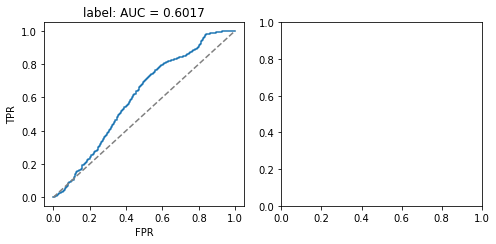

In [128]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

#plot_roc(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'], 'h1n1_vaccine', ax=ax[0])
plot_roc(y_eval['label'], y_preds['label'], 'label', ax=ax[0])

fig.tight_layout()

## An AUC score of 0.5 is no better than random, and an AUC score of 1.0 is a perfect model ##


In [129]:
roc_auc_score(y_eval, y_preds)

0.6016919494549092

In [130]:
full_pipeline.fit(new_train_df, new_label_df)

None


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [134]:
test_set = pd.read_csv(DATA_PATH / "test.csv", index_col="tripid")
test_set


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
213284604,10.5,924,42,2.448600,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
213286352,10.5,4249,20,0.000000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
213293973,10.5,1552,255,2.658800,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
213294622,10.5,462,16,0.000000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
213298687,10.5,814,392,12.369200,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47
213299545,10.5,2495,351,16.530800,9,2/1/2020 7:13,2/1/2020 7:55,6.99819,79.9378,7.13916,79.8726,1156.97
213302332,10.5,1108,454,23.929200,43,2/1/2020 7:47,2/1/2020 8:05,6.79064,79.8878,6.81875,79.8859,196.81
213302671,10.5,2737,320,18.496000,17,2/1/2020 7:48,2/1/2020 8:33,6.81545,79.9707,6.82144,79.8662,688.43
213305594,10.5,1154,29,0.000000,130,2/1/2020 8:11,2/1/2020 8:30,6.82920,79.9798,6.79732,79.9309,288.77


In [135]:
test_probs = full_pipeline.predict_proba(test_set)
test_probs

C:\Users\DELL\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


[array([[0.08904378, 0.91095622],
        [0.1444134 , 0.8555866 ],
        [0.09199352, 0.90800648],
        ...,
        [0.08577849, 0.91422151],
        [0.08938846, 0.91061154],
        [0.09331108, 0.90668892]])]

In [133]:
submission_set = pd.read_csv(DATA_PATH / "sample_submission.csv", index_col="tripid")
submission_set.head()


,prediction
tripid,
213284604,1
213286352,0
213293973,0
213294622,1
213298687,1


In [111]:
#submission_set['h1n1_vaccine'] = test_probs[0][:,1]
submission_set['prediction'] = test_probs[0][:,1]

submission_set


,prediction
tripid,
213284604,0.910956
213286352,0.855587
213293973,0.908006
213294622,0.913122
213298687,0.911227
213299545,0.878964
213302332,0.913615
213302671,0.896107
213305594,0.907298


In [107]:
submission_set.loc[submission_set['prediction'] > 0.5, 'prediction'] = 1
submission_set.loc[submission_set['prediction'] <= 0.5, 'prediction'] = 0
submission_set


,prediction
tripid,
213284604,1.0
213286352,1.0
213293973,1.0
213294622,1.0
213298687,1.0
213299545,1.0
213302332,1.0
213302671,1.0
213305594,1.0


In [110]:
submission_set.to_csv('160374E_submission_01.csv', index=True)
print("Completed!")


Completed!
